In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras import datasets, layers, utils, Sequential, Model
import matplotlib.pyplot as plt

# Utils

In [2]:
(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
train_x = train_x.reshape([train_x.shape[0], -1]) / 255.
test_x = test_x.reshape([test_x.shape[0], -1]) / 255.

train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

In [3]:
print(train_x.shape, test_x.shape)

(60000, 784) (10000, 784)


In [4]:
def plot_wb(model):
    pos_last_layer = len(model.layers) - 1

    for i, l in enumerate(model.layers):

        # Take all dense layer except last one,
        if i != pos_last_layer and  i % 2 == 0:

            # Plot.
            fig = plt.figure(figsize=(15,5))

            fig.add_subplot(1,2,1)
            plt.title("weights " + l.name)
            plt.hist(l.get_weights()[0].flatten(), bins=100);

            fig.add_subplot(1,2,2)
            plt.title("biases " + l.name)
            plt.hist(l.get_weights()[1].flatten(), bins=100);

def wb_non_zero_percentage(model):
    pos_last_layer = len(model.layers) - 1

    for i, l in enumerate(model.layers):

        # Take all dense layer except last one,
        if i != pos_last_layer and  i % 2 == 0:
            w, b = model.layers[0].get_weights()

            non_zero_w = tf.math.count_nonzero(w)
            total_w = tf.reshape(w, [-1]).shape[0]
            res_w = (non_zero_w / total_w).numpy() * 100

            non_zero_b = tf.math.count_nonzero(w)
            total_b = tf.reshape(w, [-1]).shape[0]
            res_b = (non_zero_b / total_b).numpy() * 100

            print("Percentage of non-zero value " + l.name + ": w = {} | b = {}".format(res_w, res_b))

# Model creation

In [5]:
# class DSD_layer(Model):
#     def __init__(self, sparse_training = False, sparsity=0.5):
#         super(DSD_layer, self).__init__()
        
#         self.sparse_training = sparse_training
#         self.sparsity = sparsity
    
#     def call(self, x):
#         if self.sparse_training:
#             print("sparse_training")
#             return tf.custom_gradient|(lambda x: self.func(x))(x)
        
#         print("Regular")
#         return x
    
#     def func(self, x):
    
#         qk = tfp.stats.percentile(tf.math.abs(x), q = self.sparsity * 100)
#         f = tf.where(tf.math.abs(x) <= qk, 0., x)

#         #mask = tf.where(tf.math.abs(x) <= qk, 0., 1.)
        
#         def grad(dy):
            
#             qk = tfp.stats.percentile(tf.math.abs(dy), q = self.sparsity * 100)
#             mask = tf.where(tf.math.abs(dy) <= qk, 0., 1.)
#             return dy * mask

#         return f, grad

# class DSD_layer(Model):
#     def __init__(self, sparsity, sparse_training = False):
#         super(DSD_layer, self).__init__()
        
#         self.sparse_training = sparse_training
#         self.sparsity = sparsity
    
#     def call(self, x):
#         if self.sparse_training:
#             print("sparse_training")
        
#             qk = tfp.stats.percentile(tf.math.abs(x), q = self.sparsity * 100)
#             mask = tf.where(tf.math.abs(x) < qk, 0., 1.)
#             return x * mask
        
#         print("Regular")
#         return x

# class DSD_layer(Model):
#     def __init__(self, sparsity, sparse_training = False):
#         super(DSD_layer, self).__init__()
        
#         self.sparse_training = sparse_training
#         self.sparsity = sparsity
    
#     def call(self, x):
#         if self.sparse_training:
#             print("sparse_training")
#             # return x * mask
#             return x
    
        
#         print("Regular")
#         return x

In [6]:
#TODO: When creating NN model, can't access weights because it wasn't initialize yet.
# 

In [7]:
class NN(Model):
    def __init__(self, inputs_shape= 28 * 28, sparsity=0.5):
        super(NN, self).__init__()
        
        self.is_train_on_sparse = tf.Variable(False)
        self.inputs_shape = inputs_shape
        self.sparsity = sparsity
        
        self.fc1 = layers.Dense(512, activation="relu", kernel_initializer='glorot_uniform')
#         self.dsd1 = DSD_layer(sparsity)
        self.fc2 = layers.Dense(256, activation="relu", kernel_initializer='glorot_uniform')
#         self.dsd2 = DSD_layer(sparsity)
        self.fc3 = layers.Dense(128, activation="relu", kernel_initializer='glorot_uniform')
#         self.dsd3 = DSD_layer(sparsity)
        self.fc4 = layers.Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
        
    def reset_masks(self):
        self.masks = []
        
        for layer in [self.fc1, self.fc2, self.fc3]:
            
            print(layer.get_weights())
            w, b = layer.get_weights()
            tf_w = tf.Variable(np.ones_like(w))
            tf_b = tf.Variable(np.ones_like(b))
            
            self.masks.append((tf_w, tf_b))
        
        return self.masks
    
    def prune_layers(self):
    
        for i, (layer, (w, b)) in enumerate(zip([self.fc1, self.fc2, self.fc3], self.masks)):
            curr_wb = layer.get_weights()
            
            # Get pruning masks
            mask_w, mask_b = self.get_pruning_masks(curr_wb)
            # Keep track of masks for "Training on Sparse" step.
            self.masks[i][0].assign(mask_w)
            self.masks[i][1].assign(mask_b)
            
            # Apply masks to each layer.
            curr_wb[0].assign(curr_wb[0] * mask_w)
            curr_wb[1].assign(curr_wb[1] * mask_b)

            layer.set_weights(curr_wb)
            
        
    def get_pruning_masks(self, wb):
        """
            Returns mask for weights and biases.
        """

        w = tf.convert_to_tensor(wb[0], dtype=tf.float32)
        b = tf.convert_to_tensor(wb[1], dtype=tf.float32)

        # Weight
        qk = tfp.stats.percentile(tf.math.abs(w), q = self.sparsity * 100)
        mask_w = tf.where(tf.math.abs(w) < qk, 0., 1.)

        # Bias
        qk = tfp.stats.percentile(tf.math.abs(b), q = self.sparsity * 100)
        mask_b = tf.where(tf.math.abs(b) < qk, 0., 1.)

        #print("Mask shape:", mask_w.shape, mask_b.shape)

        return mask_w, mask_b
    
    def activate_train_on_sparse(self):
        self.is_train_on_sparse.assign(True)
        
    def deactivate_train_on_sparse(self):
        self.is_train_on_sparse.assign(False)
    
    def call(self, x):
        x = self.fc1(x)
        
        #x = self.dsd1(x)
        x = tf.cond(self.is_train_on_sparse, lambda: x * self.masks[0][0], lambda: x)
     
        x = self.fc2(x)
        #x = self.dsd2(x)
        x = tf.cond(self.is_train_on_sparse, lambda: x * self.masks[1][0], lambda: x)
        
        x = self.fc3(x)
        #x = self.dsd3(x)
        x = tf.cond(self.is_train_on_sparse, lambda: x * self.masks[2][0], lambda: x)
        
        x = self.fc4(x)
        return x

    def model(self):
        x = layers.Input(shape=self.inputs_shape)
        return Model(inputs=[x], outputs = self.call(x))        

In [8]:
sparsity_global_variable = 0.5
model = NN(sparsity=sparsity_global_variable)
model.model().summary()
model.reset_masks()
# model.build(input_shape = (None, 28 * 28))
# model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.06028548,  0.05226102, -0.05613127, ...,  0.00377046,
        -0.00800106,  0.00787213],
       [ 0.06297064,

In [9]:
model.masks

ListWrapper([_TupleWrapper((<tf.Variable 'Variable:0' shape=(784, 512) dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

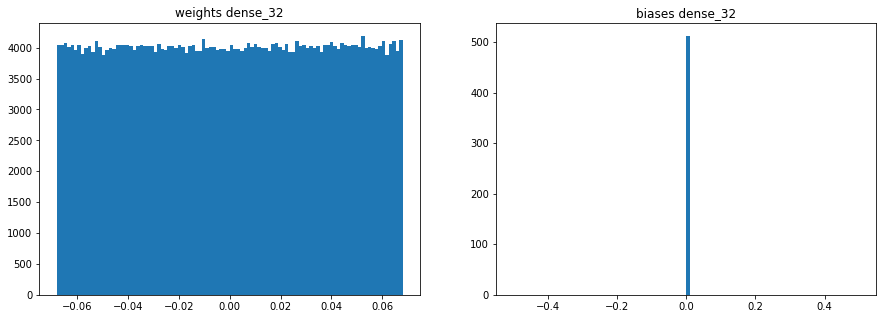

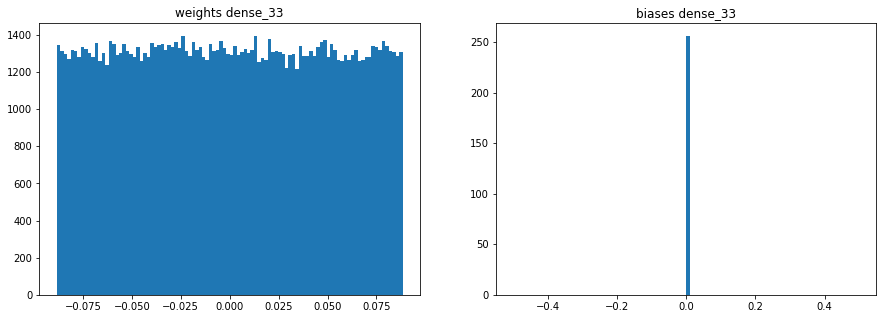

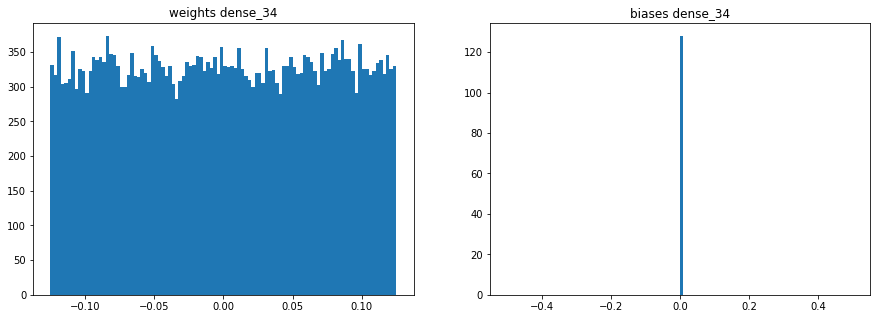

In [103]:
plot_wb(model)

# I/ Training

In [80]:
model.fit(train_x, train_y, epochs=1, workers=1)

Regular
Regular
Regular
Regular
Regular
Regular
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3320 - accuracy: 0.9002


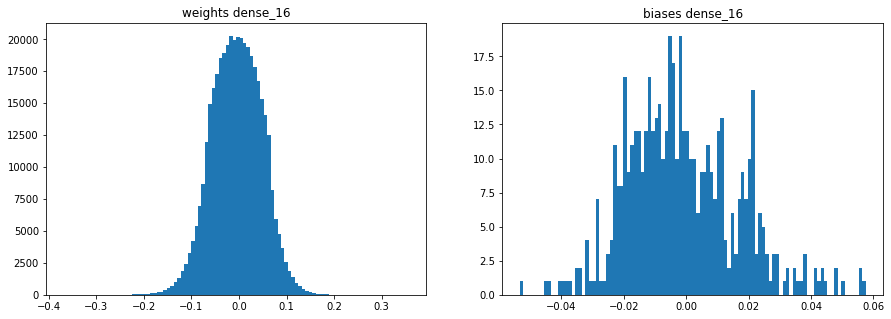

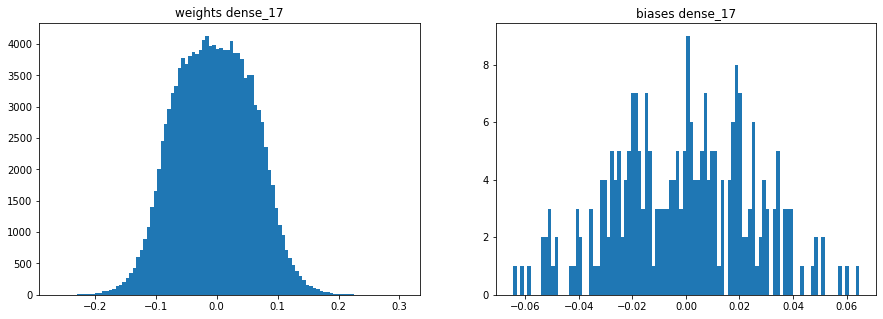

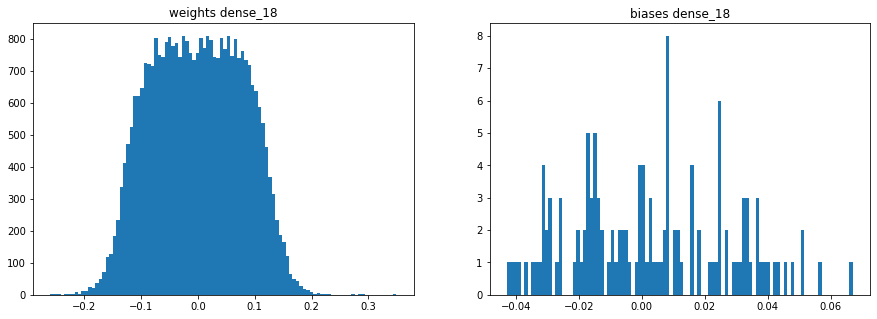

In [81]:
plot_wb(model)

# II/ Prune the network

In [59]:
# sparsity = 0.25
# w = model.layers[0].get_weights()[0]

# qk = tfp.stats.percentile(tf.math.abs(w), q = sparsity * 100)
# pruned = tf.where(tf.math.abs(w) <= qk, 0., w)

# non_zero = tf.math.count_nonzero(pruned)
# total = tf.reshape(w, [-1]).shape[0]
# print("Percentage of non zero value:", (non_zero / total).numpy())

In [60]:
# plt.figure()
# plt.hist(pruned.numpy().flatten(), bins=100, range=(-0.055, 0.055));

In [82]:
def pruning(wb, sparsity):
    """
        Returns mask for weights and biases.
    """

    w = tf.convert_to_tensor(wb[0], dtype=tf.float32)
    b = tf.convert_to_tensor(wb[1], dtype=tf.float32)
    
    # Weight
    qk = tfp.stats.percentile(tf.math.abs(w), q = sparsity * 100)
    mask_w = tf.where(tf.math.abs(w) < qk, 0., 1.)
    
    # Bias
    qk = tfp.stats.percentile(tf.math.abs(b), q = sparsity * 100)
    mask_b = tf.where(tf.math.abs(b) < qk, 0., 1.)
    
    #print("Mask shape:", mask_w.shape, mask_b.shape)
    
    return mask_w, mask_b

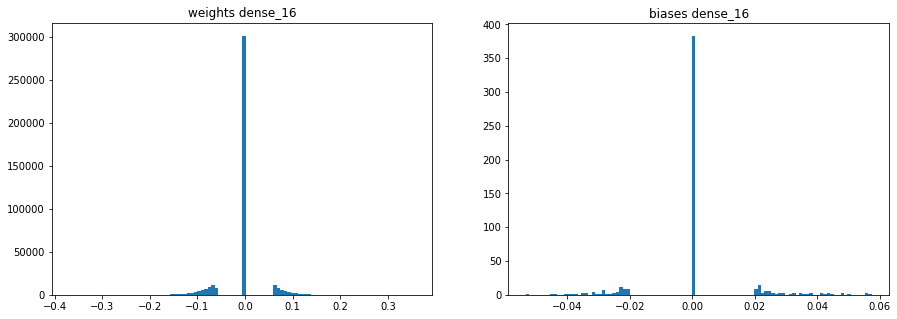

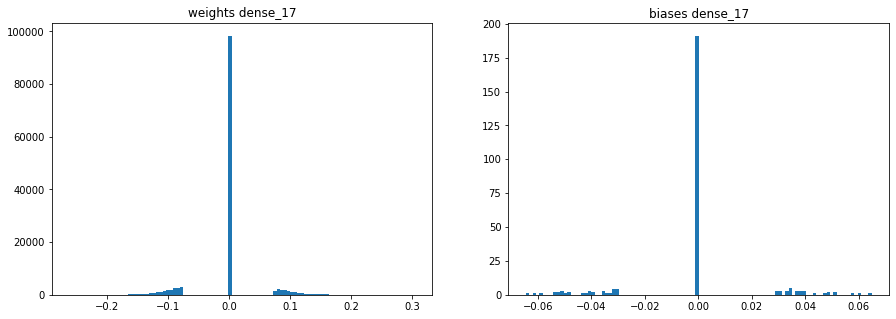

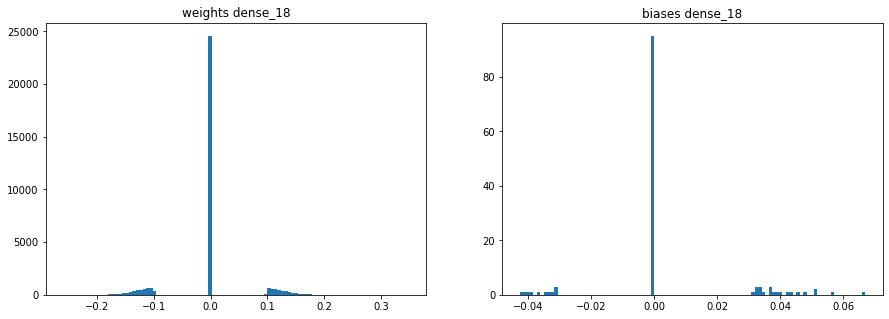

In [83]:
pos_last_layer = len(model.layers) - 1

for i, l in enumerate(model.layers):
    
    # Take all dense layer except last one,
    if i != pos_last_layer and  i % 2 == 0:
        
        wb = l.get_weights()
        
        mask_w, mask_b = pruning(wb, sparsity_global_variable)
        # Apply mask to weights
        wb[0] = wb[0] * mask_w
        # Apply mask to biases
        wb[1] = wb[1] * mask_b
        
        l.set_weights(wb)
        
        # Plot.
        fig = plt.figure(figsize=(15,5))
        
        fig.add_subplot(1,2,1)
        plt.title("weights " + l.name)
        plt.hist(l.get_weights()[0].flatten(), bins=100);
        
        fig.add_subplot(1,2,2)
        plt.title("biases " + l.name)
        plt.hist(l.get_weights()[1].flatten(), bins=100);

In [84]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense_16: w = 25.00024912308674 | b = 25.00024912308674
Percentage of non-zero value dense_17: w = 25.00024912308674 | b = 25.00024912308674
Percentage of non-zero value dense_18: w = 25.00024912308674 | b = 25.00024912308674


# III/ Train on Sparse

In [85]:
model.layers[1].sparse_training = False
model.layers[3].sparse_training = False
model.layers[5].sparse_training = False

In [86]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_x, train_y, epochs=1)

Regular
Regular
Regular
Regular
Regular
Regular
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1085 - accuracy: 0.9681


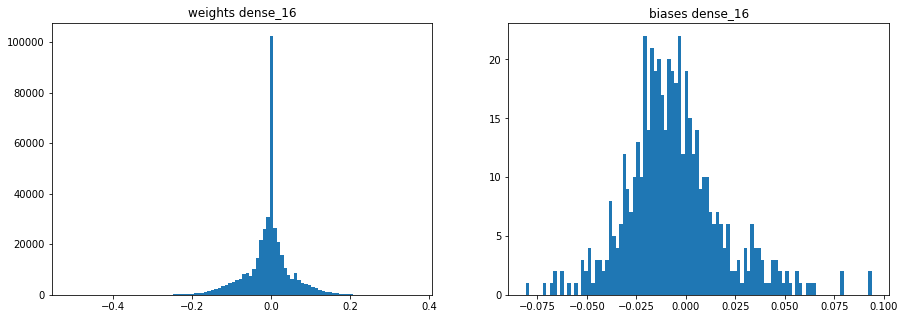

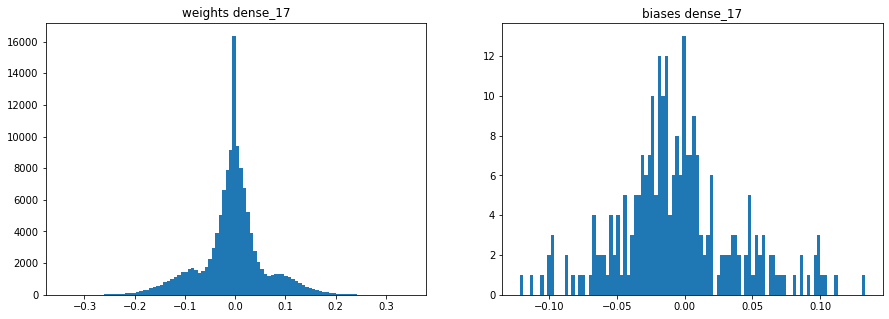

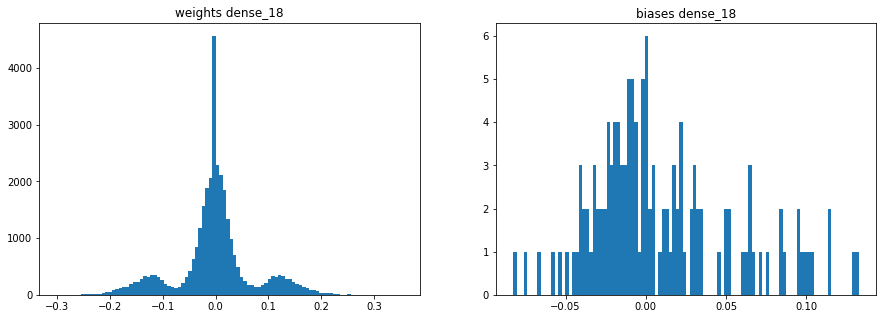

In [87]:
plot_wb(model)

In [88]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense_16: w = 83.82618183992348 | b = 83.82618183992348
Percentage of non-zero value dense_17: w = 83.82618183992348 | b = 83.82618183992348
Percentage of non-zero value dense_18: w = 83.82618183992348 | b = 83.82618183992348
